In [34]:
import pandas as pd
import networkx as nx
from collections import Counter
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import spotipy 

In [35]:
gBp = nx.read_graphml('C:/Users/perem/OneDrive/Escriptori/2n AI/2n semestre/Graph and Network Analysis/PROJECT/FINALFINAL/gBp.graphml')
gDp = nx.read_graphml('C:/Users/perem/OneDrive/Escriptori/2n AI/2n semestre/Graph and Network Analysis/PROJECT/FINALFINAL/gDp.graphml')

In [36]:
def plot_degree_distribution(degree_dict: dict, normalized: bool = False, loglog: bool = False) -> None:
    """
    Plot degree distribution from dictionary of degree counts.

    :param degree_dict: dictionary of degree counts (keys are degrees, values are occurrences).
    :param normalized: boolean indicating whether to plot absolute counts or probabilities.
    :param loglog: boolean indicating whether to plot in log-log scale.
    """
    # ------- IMPLEMENT HERE THE BODY OF THE FUNCTION ------- #
    degrees = np.array(list(degree_dict.keys()))
    counts = np.array(list(degree_dict.values()))

    if normalized:
        total = counts.sum()
        counts = counts / total
    
    plt.figure(figsize=(7, 4))
    
    if loglog:
        plt.loglog(degrees, counts, marker='o', linestyle='None', markersize=8, color='teal', label='Degree Distribution')
        plt.xlabel('Degree (log scale)', fontsize=14)
        plt.ylabel('Frequency (log scale)' if not normalized else 'Probability (log scale)', fontsize=14)
        plt.title('Degree Distribution for Graph (LOG)')
    else:
        plt.plot(degrees, counts, marker='o', linestyle='None', markersize=8, color='teal', label='Degree Distribution')
        plt.xlabel('Degree', fontsize=14)
        plt.ylabel('Frequency' if not normalized else 'Probability', fontsize=14)
        plt.title('Degree Distribution for Graph')

    plt.grid(False)
    plt.show()
    # ----------------- END OF FUNCTION --------------------- #


def get_degree_distribution(g: nx.Graph) -> dict:
    """
    Get the degree distribution of the graph.

    :param g: networkx graph.
    :return: dictionary with degree distribution (keys are degrees, values are number of occurrences).
    """
    degree_count = Counter(dict(g.degree()).values())
    return dict(degree_count)

In [37]:
def compute_mean_audio_features(tracks_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the mean audio features for tracks of the same artist.

    :param tracks_df: tracks dataframe (with audio features per each track).
    :return: artist dataframe (with mean audio features per each artist).
    """
    audio_feature_columns = ['danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    
    mean_features_df = tracks_df.groupby(['artist_id', 'artist_name'])[audio_feature_columns].mean().reset_index()
    return mean_features_df

In [38]:
songs = pd.read_csv('songs.csv')
mean_audio_features = compute_mean_audio_features(songs)

In [39]:
def norm_dataframe(df: pd.DataFrame, features: list):
    
    for feature in features:
        df[feature] = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())
    return df

def plot_audio_features(sp, artists_audio_feat: pd.DataFrame, artist1_id: str, artist2_id: str) -> None:
    """
    Plot a (single) figure with a plot of mean audio features of two different artists.

    :param artists_audio_feat: dataframe with mean audio features of artists.
    :param artist1_id: string with id of artist 1.
    :param artist2_id: string with id of artist 2.
    :return: None
    """
    features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    
    artists_audio_feat = norm_dataframe(artists_audio_feat, features) 
    artist1_name = sp.artist(artist1_id)['name']
    artist2_name = sp.artist(artist2_id)['name']
    
    artist1_info = artists_audio_feat.loc[(artists_audio_feat['artist_name'] == artist1_name) & (artists_audio_feat['artist_id'] == artist1_id)]
    artist2_info = artists_audio_feat.loc[(artists_audio_feat['artist_name'] == artist2_name) & (artists_audio_feat['artist_id'] == artist2_id)]

    artist1_values = artist1_info[features].values.flatten().tolist()
    artist2_values = artist2_info[features].values.flatten().tolist()

    num_vars = len(features)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    artist1_values += artist1_values[:1]
    artist2_values += artist2_values[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    ax.fill(angles, artist1_values, alpha=0.25, label=artist1_name)
    ax.plot(angles, artist1_values, label=artist1_name)
    
    ax.fill(angles, artist2_values, alpha=0.25, label=artist2_name)
    ax.plot(angles, artist2_values, label=artist2_name)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)

    plt.title('Radar Chart of Artist Features')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.show()



In [40]:
def compute_similarity(df: pd.DataFrame, similarity: str) -> np.ndarray:
    """
    Compute the similarity matrix based on the given similarity measure.

    :param df: DataFrame with the audio features.
    :param similarity: Similarity measure to use ('cosine' or 'euclidean').
    :return: Similarity matrix.
    """
    if similarity == 'cosine':
        sim_matrix = cosine_similarity(df)
    elif similarity == 'euclidean':
        sim_matrix = euclidean_distances(df)
        sim_matrix = 1 / (1 + sim_matrix)
    else:
        raise ValueError("Unsupported similarity measure. Use 'cosine' or 'euclidean'.")
    
    return sim_matrix

def plot_similarity_heatmap_all(artist_audio_features_df: pd.DataFrame, similarity: str, out_filename: str = None) -> None:
    """
    Plot a heatmap of the similarity between all artists.

    :param artist_audio_features_df: DataFrame with mean audio features of artists.
    :param similarity: String with similarity measure to use.
    :param out_filename: Name of the file to save the plot. If None, the plot is not saved.
    :return: None
    """
    artist_names = artist_audio_features_df['artist_name'].values
    features = artist_audio_features_df.drop(columns=['artist_name', 'artist_id'])

    sim_matrix = compute_similarity(features, similarity)

    sim_df = pd.DataFrame(sim_matrix, index=artist_names, columns=artist_names)

    plt.figure(figsize=(15, 12))
    sns.heatmap(sim_df, annot=False, cmap='coolwarm', cbar=True)
    plt.title(f'Heatmap of Artist Similarity ({similarity.capitalize()} Similarity)')
    plt.xlabel('Artists')
    plt.ylabel('Artists')

    if out_filename:
        plt.savefig(out_filename, bbox_inches='tight')

    plt.show()


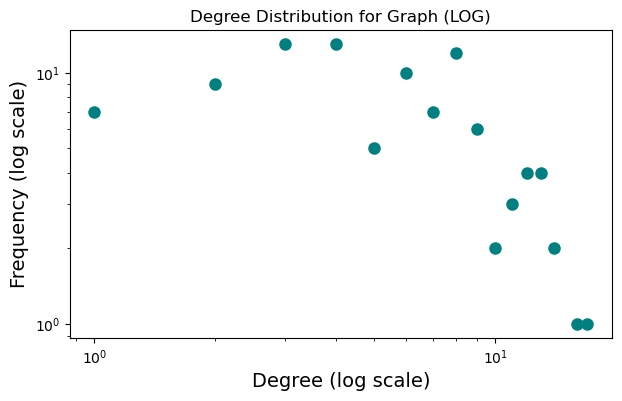

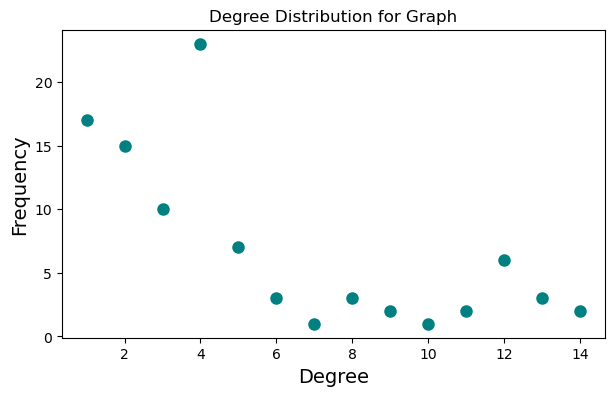

In [41]:
gBp_deg_dist = get_degree_distribution(gBp)
gDp_deg_dist = get_degree_distribution(gDp)

plot_degree_distribution(gBp_deg_dist, normalized=False, loglog=True)
plot_degree_distribution(gDp_deg_dist, normalized=False, loglog=False)


In [42]:
gw = nx.read_graphml('C:/Users/perem/OneDrive/Escriptori/2n AI/2n semestre/Graph and Network Analysis/PROJECT/FINALFINAL/gw.graphml')
def find_most_least_similar_to_singer(graph, singer_node):
    """
    Find the most and least similar artists to a specific singer in the graph.

    :param graph: NetworkX graph object with similarity weights on the edges.
    :param singer_node: Node representing the specific singer in the graph.
    :return: Tuple containing the most similar and least similar nodes to the specified singer.
    """
   
    if singer_node not in graph.nodes():
        raise ValueError(f"The specified singer node '{singer_node}' does not exist in the graph.")
    
    similarities = {}
    
    
    for node in graph.nodes():
        if node != singer_node:
            if graph.has_edge(singer_node, node):
                similarities[node] = graph[singer_node][node]['weight']
            else:
                similarities[node] = 0  


    most_similar = max(similarities, key=similarities.get)
    least_similar = min(similarities, key=similarities.get)

    return most_similar, least_similar

singer_node = '06HL4z0CvFAxyc27GXpf02'  
most_similar, least_similar = find_most_least_similar_to_singer(gw, singer_node)


print(f"Most similar to {singer_node}: {most_similar}")
print(f"Least similar to {singer_node}: {least_similar}")


Most similar to 06HL4z0CvFAxyc27GXpf02: 35l9BRT7MXmM8bv2WDQiyB
Least similar to 06HL4z0CvFAxyc27GXpf02: 5aTwY2xyrJy4cS1jlFg1oG


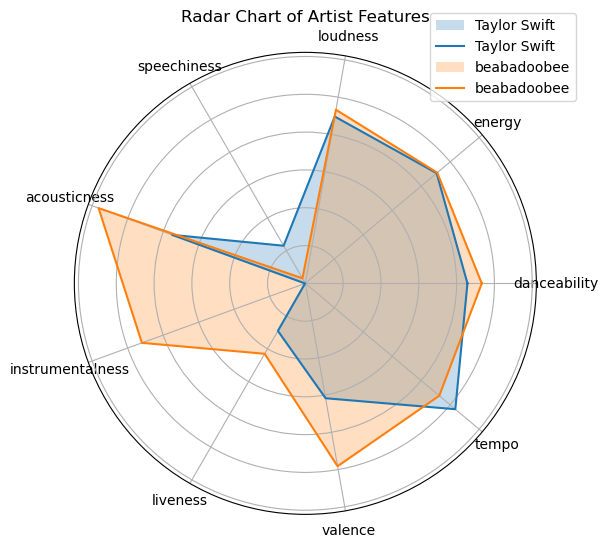

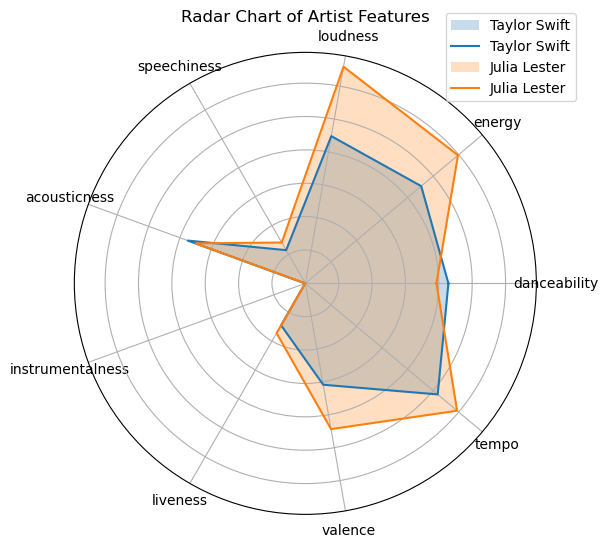

In [43]:
import spotipy
from spotipy . oauth2 import SpotifyClientCredentials

CLIENT_ID = "a96a3af9660440769efb49b1785fd7b2"
CLIENT_SECRET = "2e50c0969ed44cd0a254ad301de00f50"



auth_manager = SpotifyClientCredentials(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET
)

sp = spotipy.Spotify(auth_manager=auth_manager)
plot_audio_features(sp,mean_audio_features, singer_node, most_similar)
plot_audio_features(sp, mean_audio_features, singer_node, least_similar)

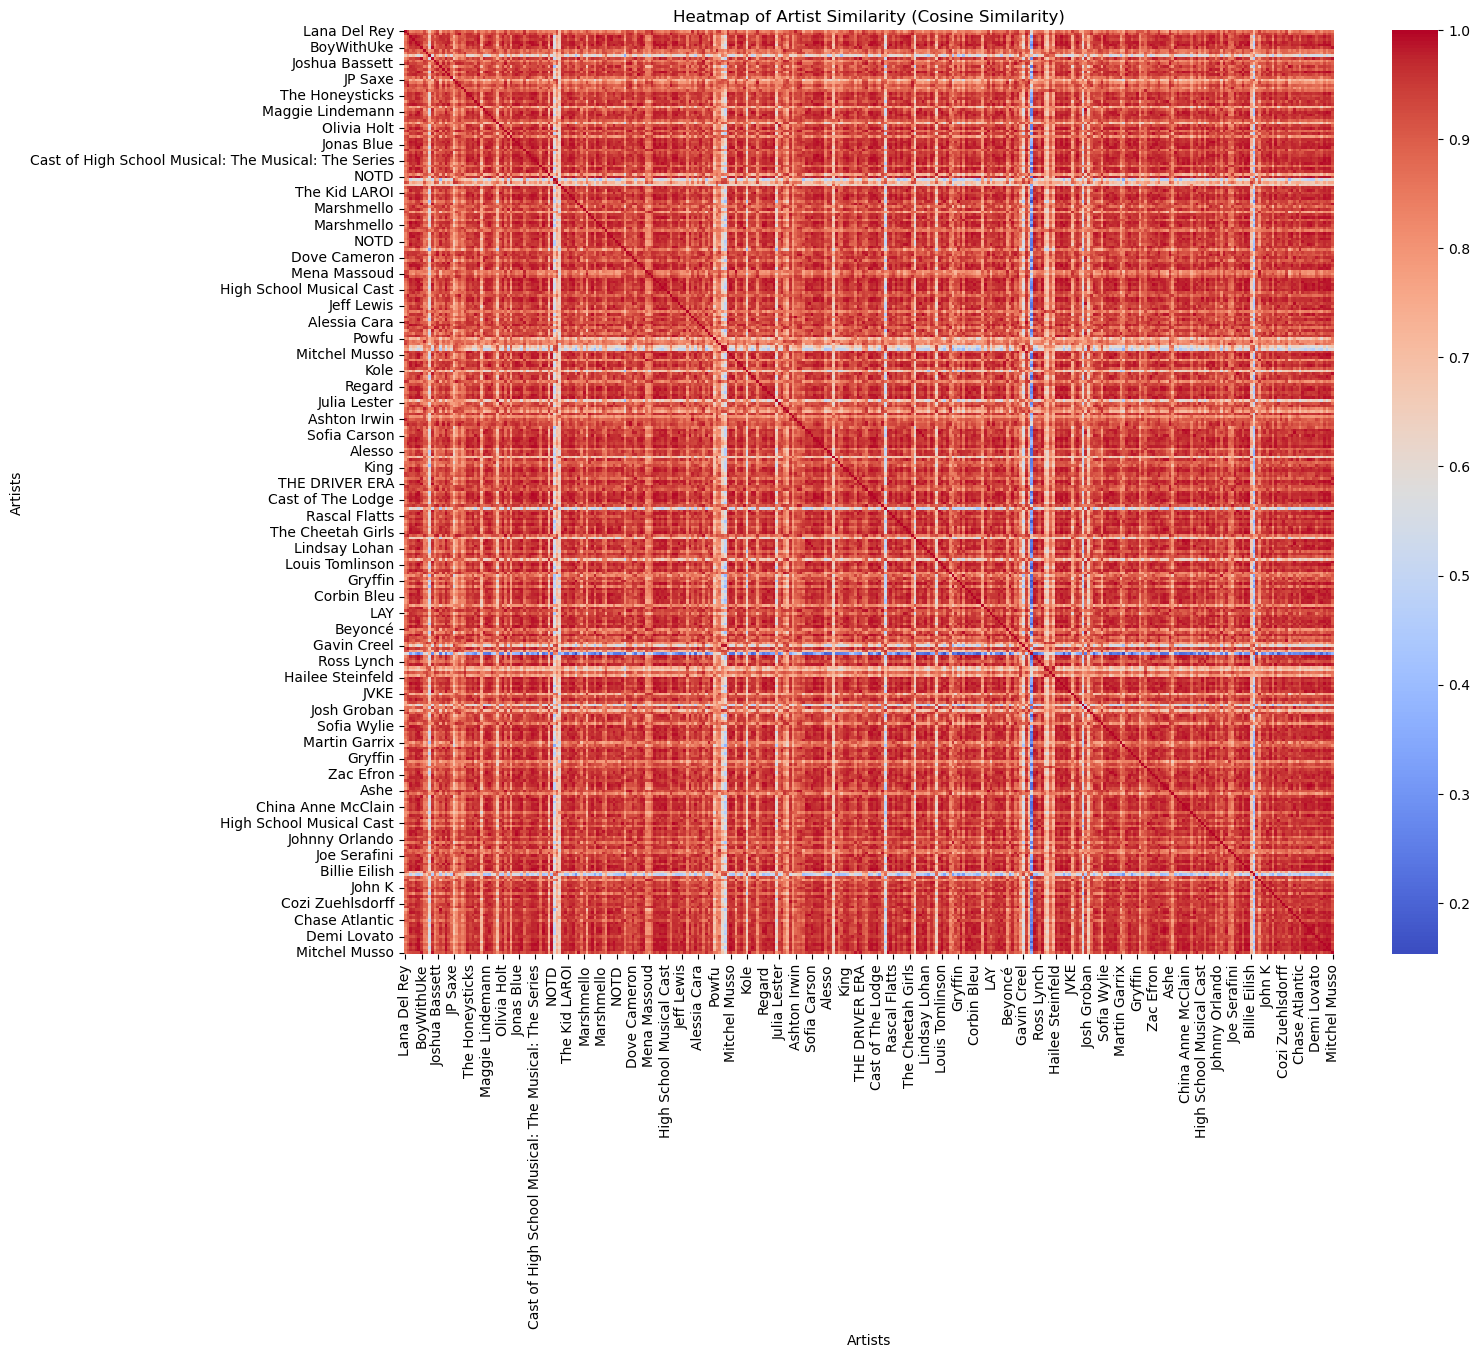

In [44]:
plot_similarity_heatmap_all(artist_audio_features_df=mean_audio_features,similarity='cosine',)

In [45]:
def degree_statistics_directed(graph):
    degrees = [d for n, d in graph.degree()]
    
    stats = { 
        "degree": {
            "min": min(degrees),
            "max": max(degrees),
            "median": sorted(degrees)[len(degrees)//2]
        },
        "number_of_nodes": graph.number_of_nodes(),
        "number_of_edges": graph.number_of_edges()
    }
    return stats

print(degree_statistics_directed(gw))

{'degree': {'min': 137, 'max': 139, 'median': 139}, 'number_of_nodes': 138, 'number_of_edges': 9547}


In [46]:
def prune_low_weight_edges(g: nx.Graph, min_weight: float = None, min_percentile: int = None, out_filename: str = None) -> nx.Graph:
    """
    Prune a graph by removing edges with weight < threshold. Threshold can be specified as a value or as a percentile.

    :param g: a weighted networkx graph.
    :param min_weight: lower bound value for the weight.
    :param min_percentile: lower bound percentile for the weight.
    :param out_filename: name of the file that will be saved.
    :return: a pruned networkx graph.
    """
    
    # Ensure only one of min_weight or min_percentile is specified
    if (min_weight is None and min_percentile is None) or (min_weight is not None and min_percentile is not None):
        raise ValueError("Specify either min_weight or min_percentile, but not both.")
    
    if min_percentile is not None:
        weights = [data['weight'] for u, v, data in g.edges(data=True)]  # Get all edge weights
        threshold = pd.Series(weights).quantile(min_percentile / 100)  # Compute the weight threshold based on percentile
    else:
        threshold = min_weight  # Use the specified min_weight as threshold
    
    # Keep edges with weight >= threshold
    edges_to_keep = [(u, v) for u, v, data in g.edges(data=True) if data['weight'] >= threshold]
    pruned_g = g.edge_subgraph(edges_to_keep).copy()  # Create a subgraph with the selected edges
    
    # Remove nodes with zero degree
    zero_degree_nodes = [node for node, degree in dict(pruned_g.degree()).items() if degree == 0]
    pruned_g.remove_nodes_from(zero_degree_nodes)
    
    # Preserve node attributes
    for node in pruned_g.nodes():
        if 'name' not in g.nodes[node]:
            pruned_g.nodes[node]['name'] = node  # Assign the node itself as name if 'name' attribute is missing
        else:
            pruned_g.nodes[node]['name'] = g.nodes[node]['name']  # Preserve the 'name' attribute
    
    # Save the pruned graph to a file if specified
    if out_filename:
        nx.write_graphml(pruned_g, out_filename)
    return pruned_g

In [47]:
gw_prunned = prune_low_weight_edges(gw, min_percentile=70)

In [48]:
print(degree_statistics_directed(gw))
print(degree_statistics_directed(gw_prunned))

{'degree': {'min': 137, 'max': 139, 'median': 139}, 'number_of_nodes': 138, 'number_of_edges': 9547}
{'degree': {'min': 1, 'max': 69, 'median': 47}, 'number_of_nodes': 137, 'number_of_edges': 2864}


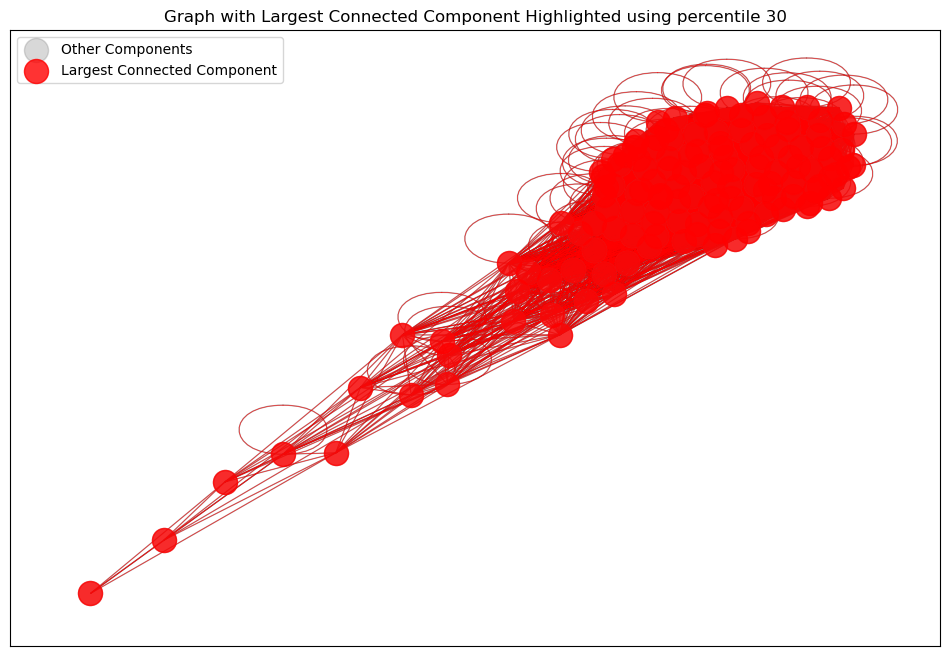

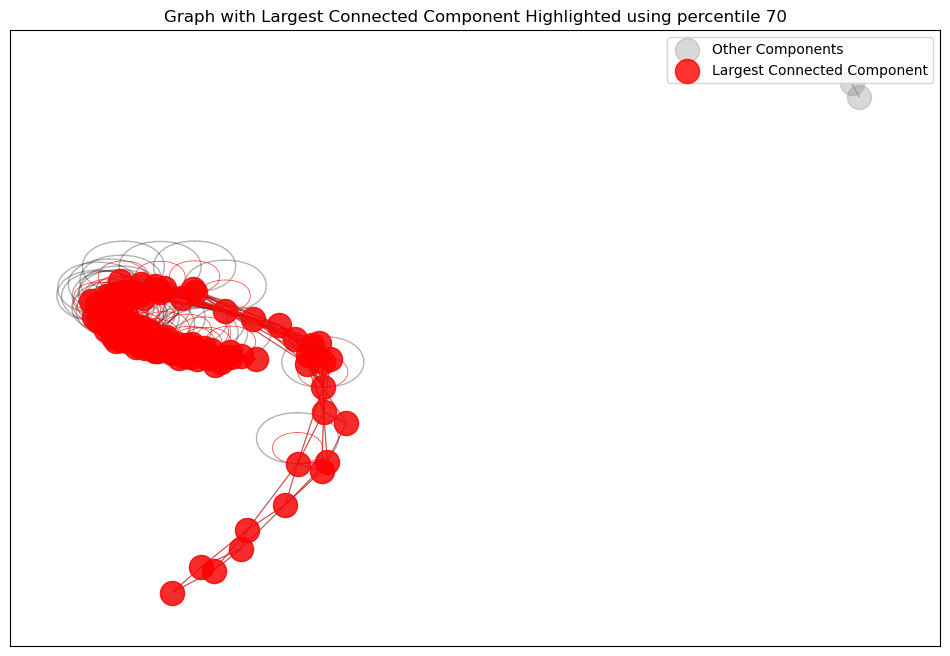

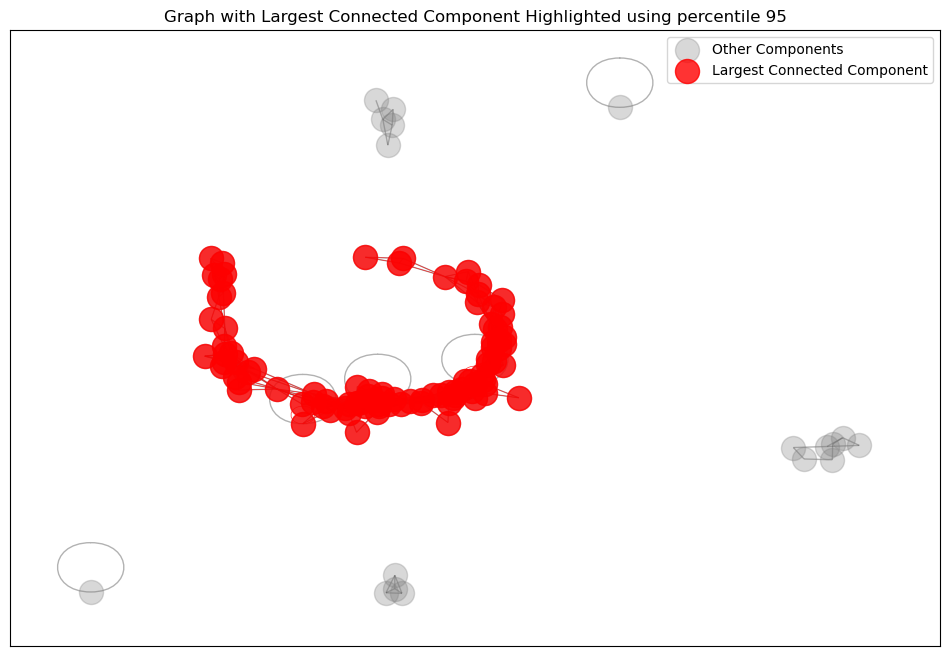

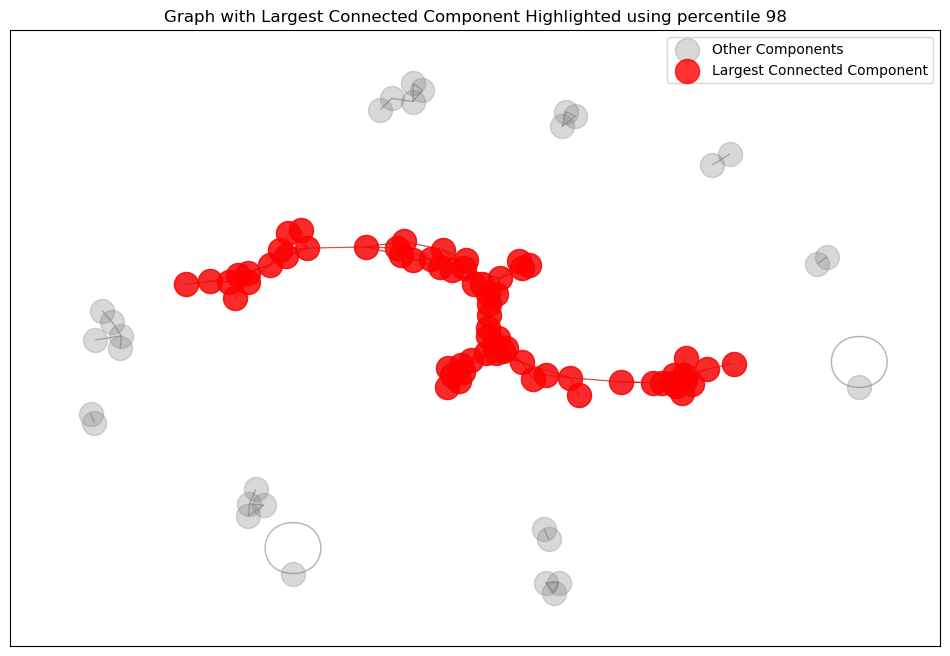

In [49]:
def largest_connected_component(graph: nx.Graph) -> nx.Graph:
    """
    Returns the largest connected component as a subgraph.
    
    :param graph: NetworkX graph.
    :return: Subgraph of the largest connected component.
    """
    largest_cc_nodes = max(nx.connected_components(graph), key=len)
    return graph.subgraph(largest_cc_nodes).copy()

def plot_largest_connected_component(graph: nx.Graph, percentile: int = 30) -> None:
    """
    Plots the graph highlighting the largest connected component.
    
    :param graph: NetworkX graph.
    :return: None
    """
    largest_cc_subgraph = largest_connected_component(graph)
    pos = nx.spring_layout(graph)

    plt.figure(figsize=(12, 8))

    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    nx.draw_networkx_nodes(graph, pos, node_color='gray', alpha=0.3, label='Other Components')

    nx.draw_networkx_edges(largest_cc_subgraph, pos, edge_color='red', alpha=0.8, width=0.5)
    nx.draw_networkx_nodes(largest_cc_subgraph, pos, node_color='red', alpha=0.8, label='Largest Connected Component')
    
    plt.title(f'Graph with Largest Connected Component Highlighted using percentile {percentile}')
    plt.legend()
    plt.show()

gw_prunned_2 = prune_low_weight_edges(gw, min_percentile=30)
gw_prunned_3 = prune_low_weight_edges(gw, min_percentile=95)
gw_prunned_4 = prune_low_weight_edges(gw, min_percentile=98)

# Plot the size of the largest connected component
plot_largest_connected_component(gw_prunned_2, 30)
plot_largest_connected_component(gw_prunned, 70)
plot_largest_connected_component(gw_prunned_3, 95)
plot_largest_connected_component(gw_prunned_4, 98)

In [55]:
gB = nx.read_graphml('C:/Users/perem/OneDrive/Escriptori/2n AI/2n semestre/Graph and Network Analysis/PROJECT/FINALFINAL/gB.graphml')
gD = nx.read_graphml('C:/Users/perem/OneDrive/Escriptori/2n AI/2n semestre/Graph and Network Analysis/PROJECT/FINALFINAL/gD.graphml')


In [64]:
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.cm as cm
import community as community_louvain
from community_louvain import best_partition

def detect_communities(g: nx.Graph, method: str) -> tuple:
    """
    Detect communities in the graph g using the specified method.

    :param g: a networkx graph.
    :param method: string with the name of the method to use. Can be (at least) 'girvan-newman' or 'louvain'.
    :return: two-element tuple, list of communities (each community is a list of nodes) and modularity of the partition.
    """
    if method == 'girvan-newman':
        communities_generator = nx.community.girvan_newman(g)
        top_level_communities = next(communities_generator)
        communities = [list(c) for c in top_level_communities]
    elif method == 'louvain':
        if g.is_directed():
            g = g.to_undirected()
        partition = community_louvain.best_partition(g)
        communities_dict = {}
        for node, comm in partition.items():
            communities_dict.setdefault(comm, []).append(node)
        communities = list(communities_dict.values())
    else:
        raise ValueError(f"Method {method} is not supported.")

    modularity = nx.community.modularity(g, communities)
    return communities, modularity

def plot_graph_with_communities(graph: nx.Graph, title: str) -> None:
    """
    Plots the graph with nodes colored by community and sized by betweenness centrality.
    
    :param graph: NetworkX graph.
    :param title: Title for the plot.
    :return: None
    """
    # Calculate betweenness centrality
    betweenness = nx.betweenness_centrality(graph)
    
    # Find communities using the greedy modularity algorithm
    communities, mod = detect_communities(graph, 'louvain')
    
    # Create a mapping of node to community index
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i
    
    # Get positions using a layout algorithm with increased spacing
    pos = nx.spring_layout(graph, k=0.3, iterations=50)
    
    # Draw nodes with colors and sizes
    plt.figure(figsize=(14, 10))
    colormap = cm.get_cmap('tab20', len(communities))
    
    for i, community in enumerate(communities):
        community_nodes = list(community)
        node_sizes = [betweenness[node] * 2000 for node in community_nodes]  # Increase node size scaling factor
        nx.draw_networkx_nodes(graph, pos, nodelist=community_nodes, node_size=node_sizes, 
                               node_color=[colormap(i)] * len(community_nodes), label=f'Community {i+1}')
    
    # Draw inter-community edges with low opacity
    nx.draw_networkx_edges(graph, pos, alpha=0.1)
    
    # Draw intra-community edges with higher opacity
    for community in communities:
        nx.draw_networkx_edges(graph, pos, edgelist=graph.subgraph(community).edges(), alpha=0.5, edge_color='gray')
    
    plt.title(title)
    plt.legend()
    plt.show()



# Plot the graphs with communities and betweenness centrality
plot_graph_with_communities(gD, title='Directed Graph gD with Communities')
plot_graph_with_communities(gB, title='Directed Graph gB with Communities')


ModuleNotFoundError: No module named 'community_louvain'